# Grid-Search on: <br> &emsp;Document Vectors using Cosine Similarity + BON

In [1]:
from ensemble_gs import read_logs, get_vectors_for_ensemble
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from scipy import sparse

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm


Run the main grid-search experiment with ensemble_gs.py first before running this notebook !!!

!python ensemble_gs.py

## Results from the grid-search on feature-wise scaling, r and C

In [2]:
# load test results
sns.set(font_scale=1.6, style="whitegrid")

with open('test_logs/dv+bon_logs.pkl', 'rb') as f:
    his = pickle.load(f)
    
df = read_logs(his)
df = df.replace("standard_with_mean", "standard")

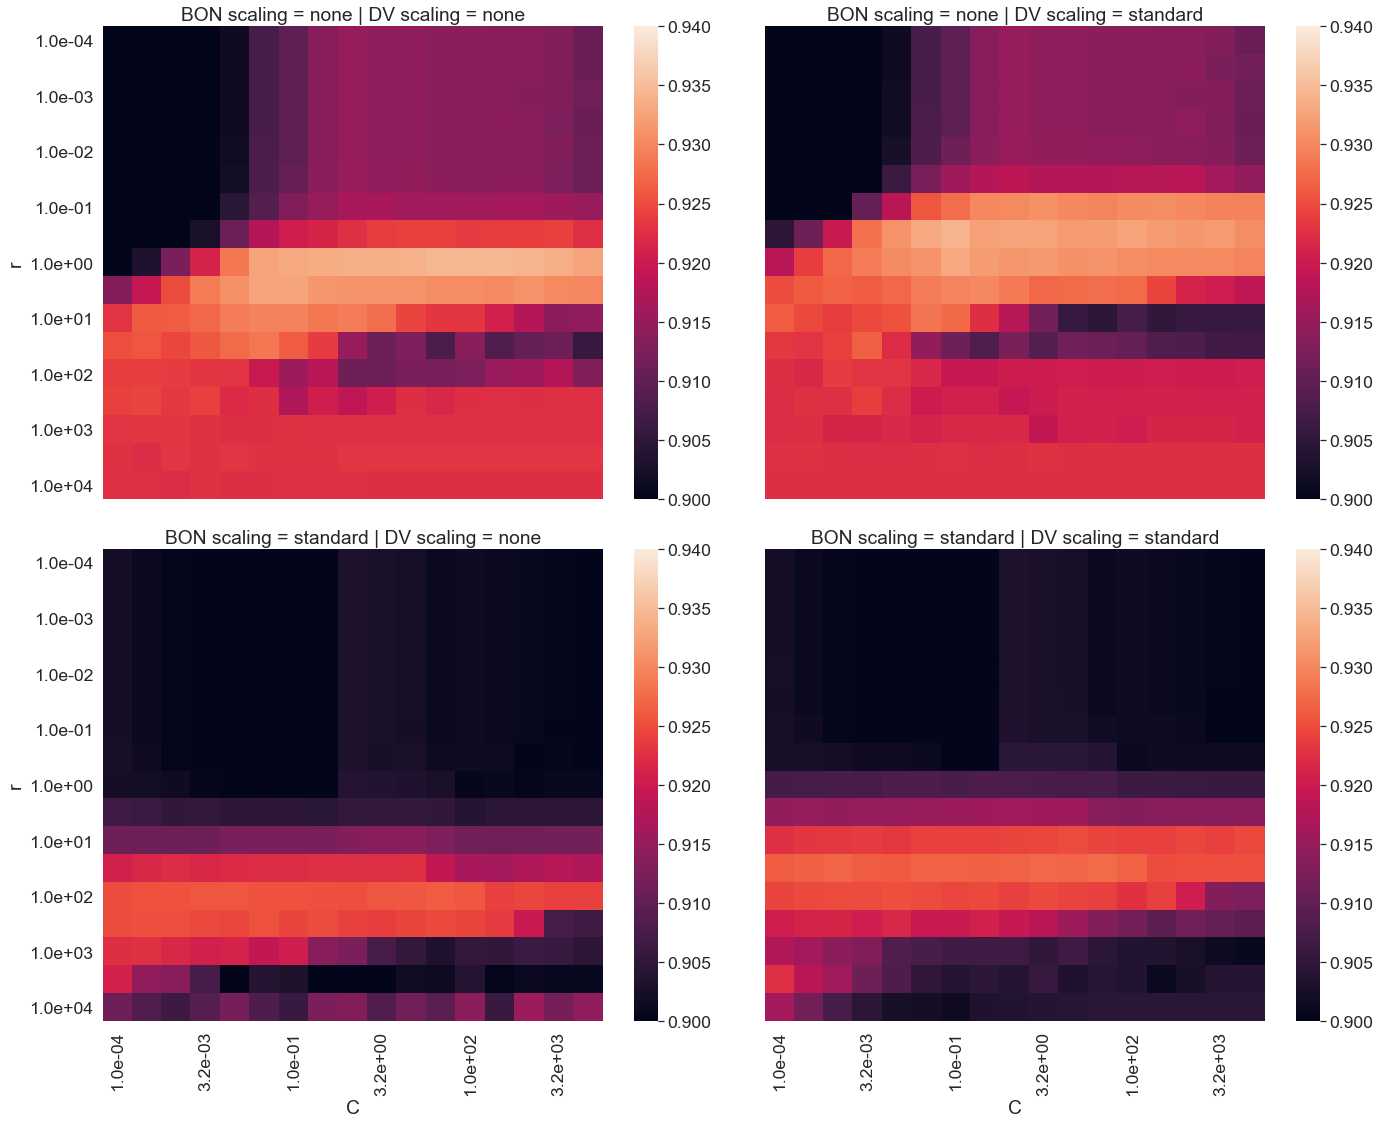

In [3]:
def draw_heatmap(x, y, v, **kwargs):
    data = kwargs.pop("data")
    d = data.pivot(index=y, columns=x, values=v)
    d = d.rename(lambda x: f"{x:.1e}", axis=0)
    d = d.rename(lambda x: f"{x:.1e}", axis=1)
    ax = sns.heatmap(d,  **kwargs)
g = sns.FacetGrid(df, col="DV scaling", row="BON scaling")
g.map_dataframe(draw_heatmap, "C", "r", "acc", vmin=0.90, vmax=0.94)
g.fig.set_size_inches(20, 16)
g.fig.tight_layout()
g.savefig("figures/dv_bon_gs.jpg")

In [4]:
# g = sns.relplot(x="C", y="acc", hue="r", col="DV scaling", row="BON scaling", data=df, hue_norm=LogNorm(1e-4, 1e4), legend="full")
# g.set(xscale="log")
# g.set(ylim=(0.9, 0.94))
# g.savefig("figures/dv_bon_gs.jpg")

Top 4 configurations in the grid-search based on validation scores

In [5]:
top = df.sort_values(by="acc", ascending=False).head(4).copy()
top

,C,r,acc,DV scaling,BON scaling
147,31.622777,1.000000,0.9344,none,none
148,100.000000,1.000000,0.9344,none,none
149,316.227766,1.000000,0.9344,none,none
125,0.100000,0.316228,0.9342,standard,none


## Test the top 4 configurations on the test set

In [6]:
os.chdir('files_root')
path_1gram = 'alldata-id_p1gram.txt'
path_3gram = "alldata-id_p3gram.txt"
path_embedding_train = 'train_vectors.txt'
path_embedding_test = 'test_vectors.txt'

bon_train, bon_test, emb_train, emb_test, y_train, y_test = get_vectors_for_ensemble(path_1gram, path_3gram, path_embedding_train, path_embedding_test, train_val_test=False)
os.chdir("..")

reading embeddings from train_vectors.txt
reading embeddings from test_vectors.txt


In [7]:
lr = LogisticRegression(solver="liblinear")

sd = StandardScaler(with_mean=True)
emb_train_sd = sd.fit_transform(emb_train)
emb_test_sd = sd.transform(emb_test)

for i, a in top.iterrows():
    dv_train = emb_train_sd if a["DV scaling"] == "standard" else emb_train
    dv_test = emb_test_sd if a["DV scaling"] == "standard" else emb_test

    lr.set_params(C=a["C"])
    lr.fit(hstack([dv_train * a["r"], bon_train]), y_train)
    test_score = lr.score(hstack([dv_test * a["r"], bon_test]), y_test)
    top.loc[i, "test score"] = test_score

top    

,C,r,acc,DV scaling,BON scaling,test score
147,31.622777,1.000000,0.9344,none,none,0.93632
148,100.000000,1.000000,0.9344,none,none,0.93532
149,316.227766,1.000000,0.9344,none,none,0.93480
125,0.100000,0.316228,0.9342,standard,none,0.93748


## DV-cosine and BON alone (without ensemble)
### Accuracy on the test set

In [8]:

lgcv = LogisticRegressionCV(Cs=np.logspace(-4, 4, 17), tol=0.001, solver='liblinear')
lgcv.fit(bon_train, y_train)
bon_test_score = lgcv.score(bon_test, y_test)

lgcv.fit(emb_train, y_train)
dv_test_score = lgcv.score(emb_test, y_test)
print("bon score:", bon_test_score)
print("dv score:", dv_test_score)

bon score: 0.91296
dv score: 0.93128


### Stats

In [9]:
mag = []
mag.append({
    "name": "DV",
    "ndim": emb_train.shape[1],
    "mean norm": np.linalg.norm(emb_train, axis=-1).mean(),
    "mean norm avg": np.linalg.norm(emb_train, axis=-1).mean()/emb_train.shape[1],
})
mag.append({
    "name": "BON",
    "ndim": bon_train.shape[1],
    "mean norm": sparse.linalg.norm(bon_train, axis=-1).mean(),
    "mean norm avg":  sparse.linalg.norm(bon_train, axis=-1).mean()/bon_train.shape[1]
})
pd.DataFrame.from_records(mag, index="name")


,ndim,mean norm,mean norm avg
name,,,
DV,500,5.367556,0.010735
BON,5142829,16.521251,0.000003
